# ISIC 2024 Challenge

This notebook contains the data preparation, processing and modelling solution of the IsIcTeam2024 team.

2024 © IsIcTeam2024

Install extra dependencies.

In [1]:
!pip install pytorch-lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 13.9 MB/s eta 0:00:00


Download files from DropBox (zip) and unzip files from challenge data zip.

In [122]:
!wget 'https://www.dropbox.com/scl/fi/nd3x002tfqpvq9p7a5kar/isic-2024-challenge.zip?rlkey=rvr8qmbucjixcika1ivtfmg0x&st=uh84g4ip&dl=0' -o isic-2024-challenge.zip

In [127]:
!unzip -o '/content/isic-2024-challenge.zip?rlkey=rvr8qmbucjixcika1ivtfmg0x&st=uh84g4ip&dl=0' -d /content/data

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: /content/data/train-image/image/ISIC_9874656.jpg  
  inflating: /content/data/train-image/image/ISIC_9874659.jpg  
  inflating: /content/data/train-image/image/ISIC_9874663.jpg  
  inflating: /content/data/train-image/image/ISIC_9874742.jpg  
  inflating: /content/data/train-image/image/ISIC_9874751.jpg  
  inflating: /content/data/train-image/image/ISIC_9874803.jpg  
  inflating: /content/data/train-image/image/ISIC_9874805.jpg  
  inflating: /content/data/train-image/image/ISIC_9874832.jpg  
  inflating: /content/data/train-image/image/ISIC_9874878.jpg  
  inflating: /content/data/train-image/image/ISIC_9874897.jpg  
  inflating: /content/data/train-image/image/ISIC_9874925.jpg  
  inflating: /content/data/train-image/image/ISIC_9874931.jpg  
  inflating: /content/data/train-image/image/ISIC_9874939.jpg  
  inflating: /content/data/train-image/image/ISIC_9874940.jpg  
  inflating: /content/data/train-image/image/ISIC_987

Import modules to visualize and preprocess data, use pandas to show metadata in table. Use cv2 to manipulate image.

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2

Load the train data (we will use as a train/valid/test, because we don't have test dataset). The original test dataset contains only 3 element (we don't have the target value for them).

In [162]:
BASE_PATH = '/content/data'
train_metadata = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
train_metadata.head()

<ipython-input-162-c2a95da5e96c>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx_5  \
0         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
1  IL_6727506     Benign  Benign     NaN     NaN     NaN     NaN   
2         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
3         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
4         NaN     Benign  Benign     NaN     NaN     NaN     NaN   

   mel_mitotic_index  mel_thick_mm  tbp_lv_dnn_lesion_confidence  
0                NaN           NaN                     97.517282  
1                NaN           NaN                      3.141455  
2                NaN           NaN                     99.804040  
3                NaN           NaN                     99.989998  
4                NaN           NaN                     70.442510  

[5 rows x 55 columns]

Show metadata details (numeric only)

In [163]:
train_metadata.describe()

target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994       5.708469   
min        -9.080269      -0.730989       9.237066       3.054228   
25%        12.469740      24.704372      23.848125      31.003148   
50%        14.713930      28.171570      26.701704      34.822580   
75%        17.137175      31.637429      29.679913      38.430298   
max        37.021680      54.306900      48.372700      58.765170   

         tbp_lv_Cext       tbp_lv_H  ...  tbp_lv_radial_color_std_max  \
count  401059.000000  401059.000000  ...                401059.000000   
mean       30.921279      54.653689  ...                     1.016459   
std         4.829345       5.520849  ...                     0.734631   
min        11.846520      -1.574164  ...                     0.000000   
25%        27.658285      51.566273  ...                     0.563891   
50%        30.804893      55.035632  ...                     0.902281   
75%        33.963868      58.298184  ...                     1.334523   
max        54.305290     105.875784  ...                    11.491140   

         tbp_lv_stdL  tbp_lv_stdLExt  tbp_lv_symm_2axis  \
count  401059.000000   401059.000000      401059.000000   
mean        2.715190        2.238605           0.306823   
std         1.738165        0.623884           0.125038   
min         0.268160        0.636247           0.052034   
25%         1.456570        1.834745           0.211429   
50%         2.186693        2.149758           0.282297   
75%         3.474565        2.531443           0.382022   
max        17.563650       25.534791           0.977055   

       tbp_lv_symm_2axis_angle       tbp_lv_x       tbp_lv_y       tbp_lv_z  \
count            401059.000000  401059.000000  401059.000000  401059.000000   
mean                 86.332073      -3.091862    1039.598221      55.823389   
std                  52.559511     197.257995     409.819653      87.968245   
min                   0.000000    -624.870728   -1052.134000    -291.890442   
25%                  40.000000    -147.022125     746.519673      -8.962647   
50%                  90.000000      -5.747253    1172.803000      67.957947   
75%                 130.000000     140.474835    1342.131540     126.611567   
max                 175.000000     614.471700    1887.766846     319.407000   

       mel_thick_mm  tbp_lv_dnn_lesion_confidence  
count     63.000000                  4.010590e+05  
mean       0.670952                  9.716220e+01  
std        0.792798                  8.995782e+00  
min        0.200000                  1.261082e-16  
25%        0.300000                  9.966882e+01  
50%        0.400000                  9.999459e+01  
75%        0.600000                  9.999996e+01  
max        5.000000                  1.000000e+02  

[8 rows x 37 columns]

Show metadata details (categorical only)

In [164]:
train_metadata.describe(include='O')

isic_id  patient_id     sex anatom_site_general  \
count         401059      401059  389542              395303   
unique        401059        1042       2                   5   
top     ISIC_0015670  IP_1117889    male     posterior torso   
freq               1        9184  265546              121902   

                image_type tbp_tile_type       tbp_lv_location  \
count               401059        401059                401059   
unique                   1             2                    21   
top     TBP tile: close-up        3D: XP  Torso Back Top Third   
freq                401059        285903                 71112   

       tbp_lv_location_simple                             attribution  \
count                  401059                                  401059   
unique                      8                                       7   
top                Torso Back  Memorial Sloan Kettering Cancer Center   
freq                   121902                                  129068   

       copyright_license   lesion_id iddx_full  iddx_1  \
count             401059       22058    401059  401059   
unique                 3       22058        52       3   
top                CC-BY  IL_6727506    Benign  Benign   
freq              188812           1    399991  400552   

                                   iddx_2 iddx_3  \
count                                1068   1065   
unique                                 14     25   
top     Benign melanocytic proliferations  Nevus   
freq                                  443    443   

                                       iddx_4                iddx_5  \
count                                     551                     1   
unique                                     26                     1   
top     Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
freq                                      228                     1   

       mel_mitotic_index  
count                 53  
unique                 7  
top               0/mm^2  
freq                  22

In [165]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

Fill NA values with pandas.ffill method

In [166]:
train_metadata.ffill(inplace=True)

In [167]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    401059 non-null  float64
 4   sex                           401059 non-null  object 
 5   anatom_site_general           401059 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

Show histrogram of target, age_approx, sex and anatom_site_general features on a plot. We can see that the most of data is negative. We use log scale on y axis.

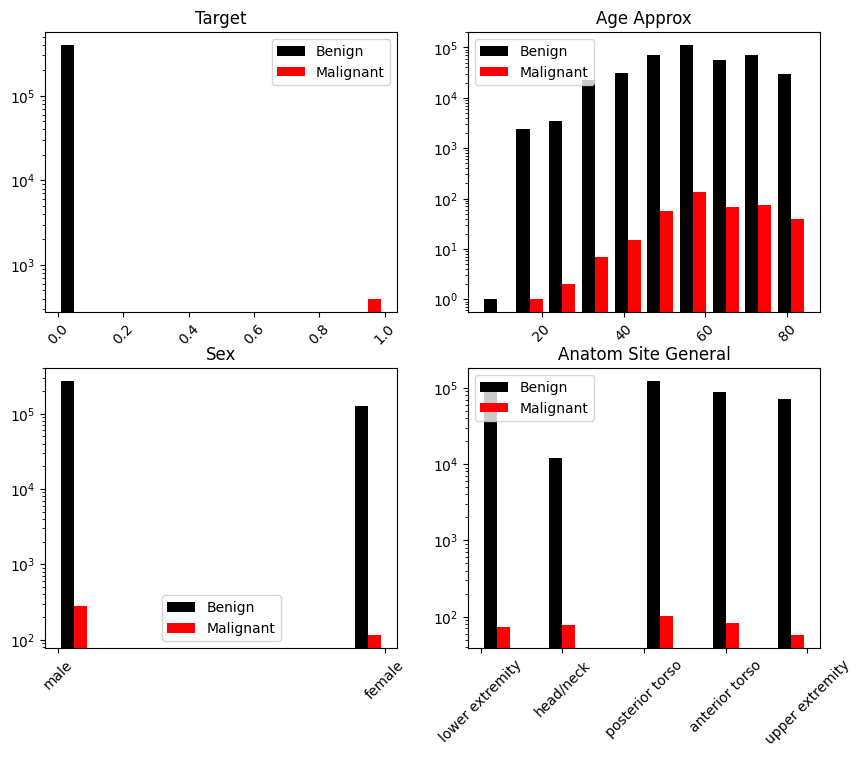

In [168]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, attribute in zip(axs.ravel(), ['target', 'age_approx', 'sex', 'anatom_site_general']):
  ax.set_title(attribute.replace('_', ' ').title())
  ax.hist(
      [train_metadata[train_metadata.target == 0][attribute], train_metadata[train_metadata.target == 1][attribute]],
      color=['Black', 'Red'],
      log=True
  )
  ax.legend(labels=['Benign', 'Malignant'])
  ax.tick_params(axis='x', rotation=45)

plt.show()

In [169]:
# Categorical features which will be one hot encoded
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

From categorical data we create dummies to encode them, we drop the first value from the dummies.

In [170]:
train_metadata = train_metadata.loc[:, [*FEAT_COLS, 'target', 'patient_id', 'isic_id']]
train_metadata = pd.get_dummies(train_metadata, columns=CATEGORICAL_COLUMNS, drop_first=True)

In [171]:
train_metadata.head()

age_approx  tbp_lv_nevi_confidence  clin_size_long_diam_mm  tbp_lv_areaMM2  \
0        60.0            2.628592e-03                    3.04        3.152561   
1        60.0            1.334303e-07                    1.10        0.919497   
2        60.0            2.959177e-04                    3.40        3.265153   
3        65.0            2.198945e+01                    3.22        6.079940   
4        55.0            1.378832e-03                    2.73        2.101708   

   tbp_lv_area_perim_ratio  tbp_lv_color_std_mean  tbp_lv_deltaLBnorm  \
0                27.476170                0.00000            5.784302   
1                12.235290                0.00000            4.987244   
2                24.184620                0.00000            6.290359   
3                14.889242                0.51452            6.400196   
4                19.902560                0.00000            6.531302   

   tbp_lv_minorAxisMM  target  patient_id  ...  \
0            1.543016       0  IP_1235828  ...   
1            0.821918       0  IP_8170065  ...   
2            1.194905       0  IP_6724798  ...   
3            2.481328       0  IP_4111386  ...   
4            0.929916       0  IP_8313778  ...   

  tbp_lv_location_Right Leg - Lower  tbp_lv_location_Right Leg - Upper  \
0                             False                               True   
1                             False                              False   
2                             False                              False   
3                             False                              False   
4                             False                              False   

   tbp_lv_location_Torso Back  tbp_lv_location_Torso Back Bottom Third  \
0                       False                                    False   
1                       False                                    False   
2                       False                                    False   
3                       False                                    False   
4                       False                                    False   

   tbp_lv_location_Torso Back Middle Third  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Back Top Third  tbp_lv_location_Torso Front  \
0                                 False                        False   
1                                 False                        False   
2                                  True                        False   
3                                 False                        False   
4                                 False                        False   

   tbp_lv_location_Torso Front Bottom Half  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Front Top Half  tbp_lv_location_Unknown  
0                                 False                    False  
1                                 False                    False  
2                                 False                    False  
3                                  True                    False  
4                                  True                    False  

[5 rows x 37 columns]

In [172]:
print("Class Distribution Before Sampling (%):")
display(train_metadata.target.value_counts(normalize=True)*100, train_metadata.target.value_counts())

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64

target
0    400666
1       393
Name: count, dtype: int64

Load and plot sample images from positive data.

In [173]:
training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')

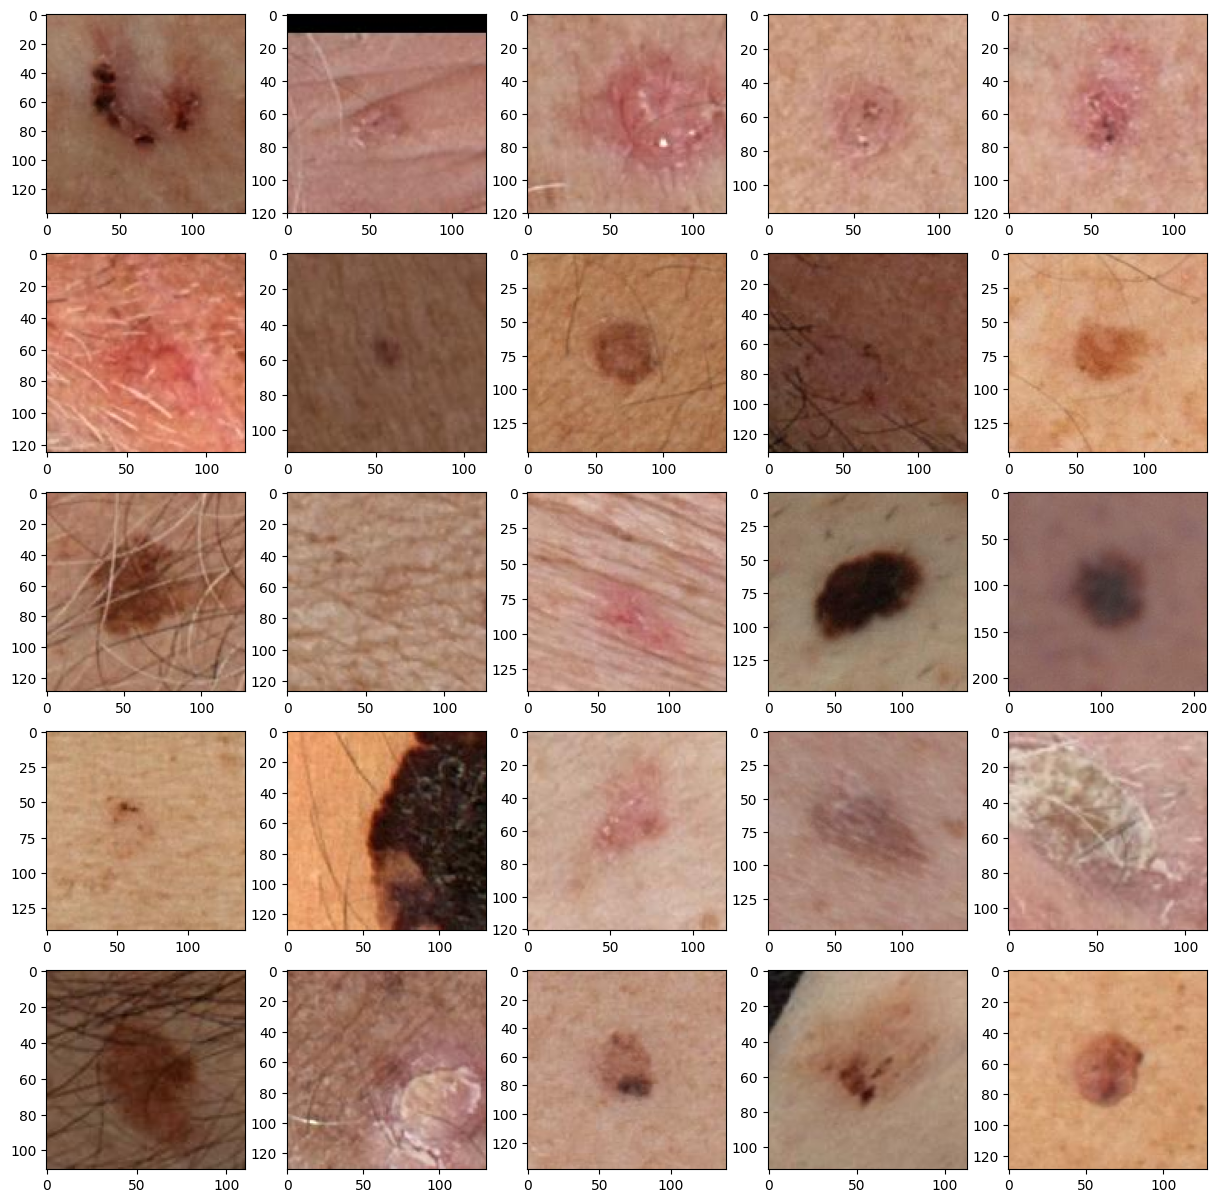

In [174]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax, isic_id in zip(axs.ravel(), train_metadata[train_metadata.target == 1].isic_id.iloc[:25]):
  # Image as Byte String
  byte_string = training_validation_hdf5[isic_id][()]

  # Convert byte string to numpy array
  nparr = np.frombuffer(byte_string, np.uint8)

  image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
  ax.imshow(image)
plt.show()

Sample 75-75 positive and negative data for test dataset

In [175]:
selected_positive_test = train_metadata[train_metadata.target == 1].sample(75, random_state=42).reset_index(drop=True)
selelected_negative_test = train_metadata[train_metadata.target == 0].sample(75, random_state=42).reset_index(drop=True)

In [176]:
test_metadata = pd.concat([selected_positive_test, selelected_negative_test]).sample(frac = 1, random_state=42).reset_index(drop=True)
test_metadata.head()

age_approx  tbp_lv_nevi_confidence  clin_size_long_diam_mm  tbp_lv_areaMM2  \
0        60.0                0.000007                    1.53        1.576281   
1        65.0               73.616195                   12.89      101.482454   
2        60.0               17.128910                    3.01        5.197973   
3        85.0               75.831120                    2.52        3.115031   
4        55.0                0.000001                    3.30        4.728842   

   tbp_lv_area_perim_ratio  tbp_lv_color_std_mean  tbp_lv_deltaLBnorm  \
0                13.405102               0.000000            4.013545   
1                19.079606               2.631318           11.309025   
2                14.918660               0.802362            6.866282   
3                13.763510               0.652644            8.513734   
4                19.874324               0.461697            5.530585   

   tbp_lv_minorAxisMM  target  patient_id  ...  \
0            1.171061       1  IP_0698187  ...   
1           10.080681       1  IP_3232631  ...   
2            2.191781       0  IP_9526638  ...   
3            1.549823       0  IP_9726832  ...   
4            2.056787       0  IP_2331257  ...   

  tbp_lv_location_Right Leg - Lower  tbp_lv_location_Right Leg - Upper  \
0                             False                              False   
1                              True                              False   
2                             False                              False   
3                             False                              False   
4                             False                              False   

   tbp_lv_location_Torso Back  tbp_lv_location_Torso Back Bottom Third  \
0                       False                                    False   
1                       False                                    False   
2                       False                                    False   
3                       False                                    False   
4                       False                                    False   

   tbp_lv_location_Torso Back Middle Third  \
0                                    False   
1                                    False   
2                                     True   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Back Top Third  tbp_lv_location_Torso Front  \
0                                 False                        False   
1                                 False                        False   
2                                 False                        False   
3                                 False                        False   
4                                 False                        False   

   tbp_lv_location_Torso Front Bottom Half  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   tbp_lv_location_Torso Front Top Half  tbp_lv_location_Unknown  
0                                 False                    False  
1                                 False                    False  
2                                 False                    False  
3                                 False                    False  
4                                 False                    False  

[5 rows x 37 columns]

Remove selected test data from train_metadata

In [177]:
train_val_metadata = train_metadata[~train_metadata.isic_id.isin([*selected_positive_test.isic_id, *selelected_negative_test.isic_id])]

In [178]:
print("Class Distribution Before Sampling In Train/Val:")
display(train_val_metadata.target.value_counts())

Class Distribution Before Sampling In Train/Val:


target
0    400591
1       318
Name: count, dtype: int64

Sample 75-75 positive and negative data for validation dataset

In [179]:
selected_positive_val = train_val_metadata[train_val_metadata.target == 1].sample(75, random_state=42).reset_index(drop=True)
selelected_negative_val = train_val_metadata[train_val_metadata.target == 0].sample(75, random_state=42).reset_index(drop=True)

In [180]:
val_metadata = pd.concat([selected_positive_val, selelected_negative_val]).sample(frac = 1, random_state=42).reset_index(drop=True)
val_metadata.head()

age_approx  tbp_lv_nevi_confidence  clin_size_long_diam_mm  tbp_lv_areaMM2  \
0        50.0                0.366743                    5.98       11.221620   
1        45.0               97.822090                    5.91       17.357850   
2        50.0               76.941210                    3.97        9.532745   
3        50.0               99.289739                    5.92       17.432914   
4        40.0               82.804954                    3.21        5.854757   

   tbp_lv_area_perim_ratio  tbp_lv_color_std_mean  tbp_lv_deltaLBnorm  \
0                23.509200               4.834564           13.411240   
1                16.526220               2.825198           14.912110   
2                16.479900               1.036851            8.491222   
3                16.703253               1.929034           10.098641   
4                15.051082               1.313961            9.015978   

   tbp_lv_minorAxisMM  target  patient_id  ...  \
0            2.890493       1  IP_8683966  ...   
1            3.684846       1  IP_7299252  ...   
2            3.150685       0  IP_9837962  ...   
3            3.847928       0  IP_0030719  ...   
4            2.339219       0  IP_3815550  ...   

  tbp_lv_location_Right Leg - Lower  tbp_lv_location_Right Leg - Upper  \
0                             False                              False   
1                             False                              False   
2                             False                              False   
3                             False                              False   
4                             False                              False   

   tbp_lv_location_Torso Back  tbp_lv_location_Torso Back Bottom Third  \
0                       False                                    False   
1                       False                                    False   
2                       False                                    False   
3                       False                                    False   
4                       False                                    False   

   tbp_lv_location_Torso Back Middle Third  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Back Top Third  tbp_lv_location_Torso Front  \
0                                 False                        False   
1                                  True                        False   
2                                 False                        False   
3                                 False                        False   
4                                 False                        False   

   tbp_lv_location_Torso Front Bottom Half  \
0                                     True   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   tbp_lv_location_Torso Front Top Half  tbp_lv_location_Unknown  
0                                 False                    False  
1                                 False                    False  
2                                 False                    False  
3                                 False                    False  
4                                 False                    False  

[5 rows x 37 columns]

In [181]:
tr_metadata = train_val_metadata[~train_val_metadata.isic_id.isin([*selected_positive_val.isic_id, *selelected_negative_val.isic_id])]

In [182]:
print("Class Distribution Before Sampling In Train/Val:")
display(tr_metadata.target.value_counts())

Class Distribution Before Sampling In Train/Val:


target
0    400516
1       243
Name: count, dtype: int64

Resample train data to balance train dataset

In [183]:
positive_train = tr_metadata.query("target==0").sample(frac=0.0075, random_state=42)
negative_train = tr_metadata.query("target==1").sample(frac=6.0, replace=True, random_state=42)
resampled_train = pd.concat([positive_train, negative_train], axis=0).sample(frac=1.0)

In [184]:
print("Class Distribution After Resampling In Train:")
display(resampled_train.target.value_counts(normalize=True)*100)

Class Distribution After Resampling In Train:


target
0    67.32407
1    32.67593
Name: proportion, dtype: float64

In [185]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(resampled_train['target']), y=resampled_train['target'])
class_weights = dict(enumerate(class_weights))

In [186]:
print("Class Weights:", class_weights)

Class Weights: {0: 0.742676431424767, 1: 1.5301783264746227}


Create train, val and test datasets

In [187]:
train_X = tr_metadata.drop(columns=['target', 'patient_id'])
train_y = tr_metadata.target.values

val_X = val_metadata.drop(columns=['target', 'patient_id'])
val_y = val_metadata.values

test_X = test_metadata.drop(columns=['target', 'patient_id'])
test_y = test_metadata.target.values

Standardize metadata in numeric columns

In [188]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X[NUMERIC_COLUMNS] = scaler.fit_transform(train_X[NUMERIC_COLUMNS])
val_X[NUMERIC_COLUMNS] = scaler.transform(val_X[NUMERIC_COLUMNS])
test_X[NUMERIC_COLUMNS] = scaler.transform(test_X[NUMERIC_COLUMNS])

In [189]:
train_X.head()

age_approx  tbp_lv_nevi_confidence  clin_size_long_diam_mm  tbp_lv_areaMM2  \
0    0.146155               -0.928732               -0.511197       -0.557187   
1    0.146155               -0.928795               -1.625295       -0.788370   
2    0.146155               -0.928788               -0.304457       -0.545531   
3    0.513871               -0.398696               -0.407827       -0.254124   
4   -0.221561               -0.928762               -0.689223       -0.665979   

   tbp_lv_area_perim_ratio  tbp_lv_color_std_mean  tbp_lv_deltaLBnorm  \
0                 1.566765              -1.403549           -0.729765   
1                -1.278521              -1.403549           -1.061360   
2                 0.952273              -1.403549           -0.519233   
3                -0.783060              -0.728769           -0.473539   
4                 0.152865              -1.403549           -0.418996   

   tbp_lv_minorAxisMM       isic_id  sex_male  ...  \
0           -0.850192  ISIC_0015670      True  ...   
1           -1.465568  ISIC_0015845      True  ...   
2           -1.147266  ISIC_0015864      True  ...   
3           -0.049449  ISIC_0015902      True  ...   
4           -1.373404  ISIC_0024200      True  ...   

   tbp_lv_location_Right Leg - Lower  tbp_lv_location_Right Leg - Upper  \
0                              False                               True   
1                              False                              False   
2                              False                              False   
3                              False                              False   
4                              False                              False   

   tbp_lv_location_Torso Back  tbp_lv_location_Torso Back Bottom Third  \
0                       False                                    False   
1                       False                                    False   
2                       False                                    False   
3                       False                                    False   
4                       False                                    False   

   tbp_lv_location_Torso Back Middle Third  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Back Top Third  tbp_lv_location_Torso Front  \
0                                 False                        False   
1                                 False                        False   
2                                  True                        False   
3                                 False                        False   
4                                 False                        False   

   tbp_lv_location_Torso Front Bottom Half  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   tbp_lv_location_Torso Front Top Half  tbp_lv_location_Unknown  
0                                 False                    False  
1                                 False                    False  
2                                 False                    False  
3                                  True                    False  
4                                  True                    False  

[5 rows x 35 columns]

Test to remove hair from images with [Squeeze algorithm](https://www.mdpi.com/2072-6694/15/1/12).

In [190]:
def remove_hair(image, image_size=(224, 224), filter_size=(5, 5), threshold=5, max_value=255):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size)

  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  blackhat_img = cv2.morphologyEx(gray_image,cv2.MORPH_BLACKHAT, kernel)

  _, mask = cv2.threshold(blackhat_img, threshold, max_value, cv2.THRESH_BINARY)

  squeezed_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)

  resized_image = cv2.resize(squeezed_image, image_size, interpolation = cv2.INTER_CUBIC)
  return resized_image


Testing hair removing from images and plot the results.

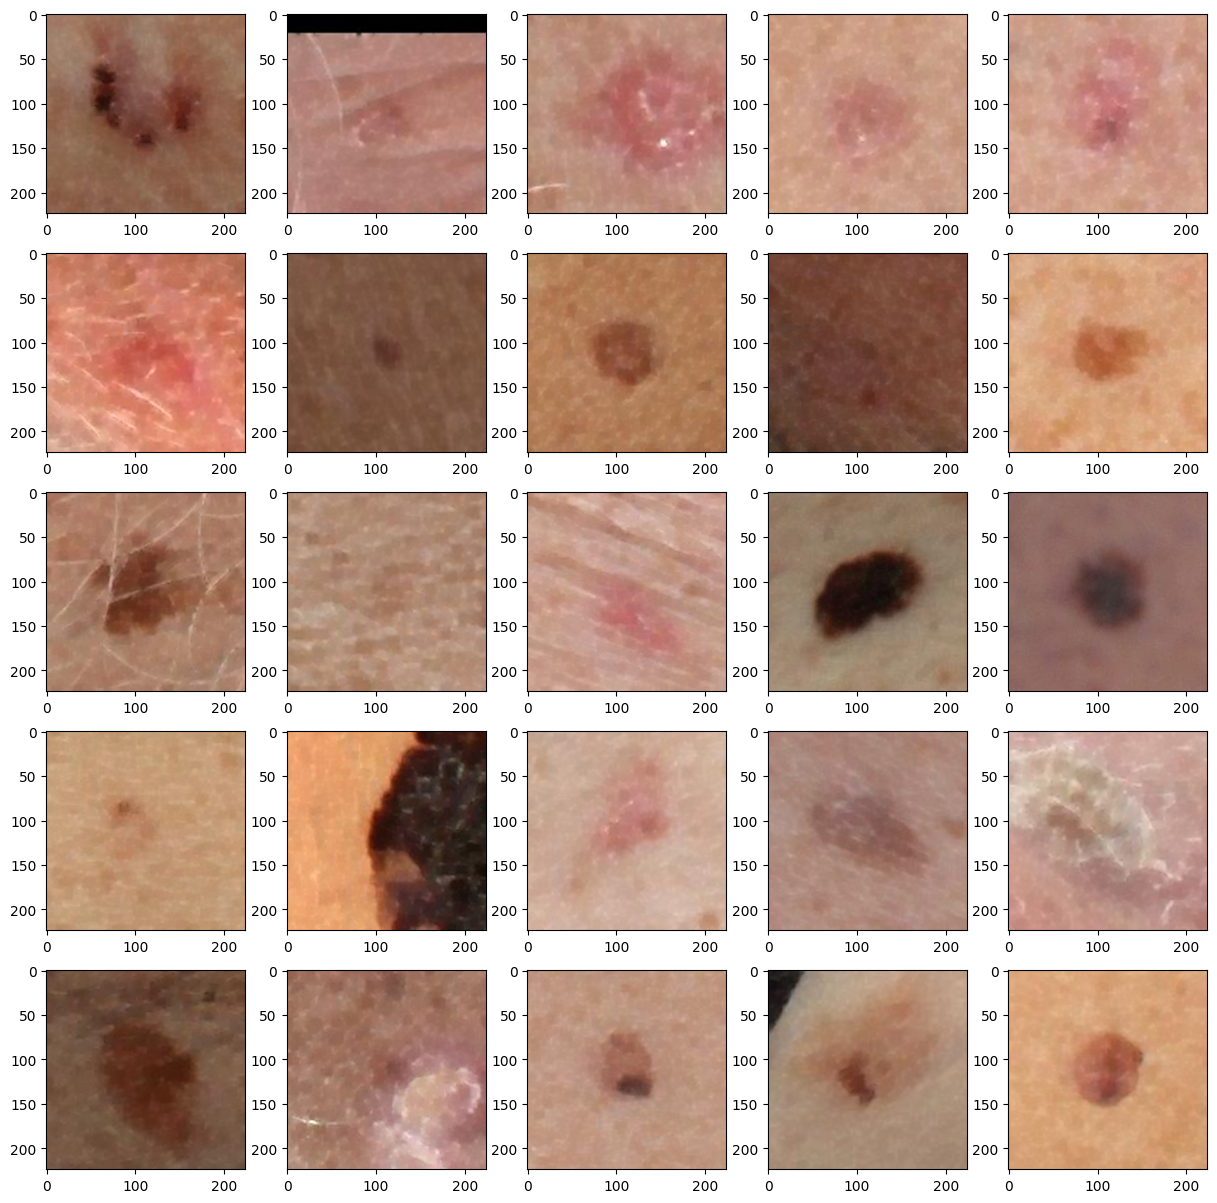

In [191]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax, isic_id in zip(axs.ravel(), train_metadata[train_metadata.target == 1].isic_id.iloc[:25]):

  image_string = training_validation_hdf5[isic_id][()]
  image_array = np.frombuffer(image_string, np.uint8)
  image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)[..., ::-1]
  squeezed_image = remove_hair(image)
  ax.imshow(squeezed_image)
plt.show()

Custom dataset to load image from hdf5 and concat with metadata and target value

In [212]:
from torch.utils.data import Dataset
import os
from PIL import Image


class Isic2024Dataset(Dataset):
    def __init__(self, metadata, targets, hdf5, transform=None, remove_hair=False):
        self.isic_ids = metadata.isic_id.values
        self.targets = targets
        self.metadata = metadata.drop(columns = ['isic_id']).values.astype(np.float32)
        self.hdf5 = hdf5
        self.transform = transform
        self.remove_hair = remove_hair

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        image_string = self.hdf5[self.isic_ids[idx]][()]
        image_array = np.frombuffer(image_string, np.uint8)
        image_decoded = cv2.imdecode(image_array, cv2.IMREAD_COLOR)[..., ::-1]  # Convert BGR to RGB

        if self.remove_hair:
          image_decoded = remove_hair(image_decoded)

        image = Image.fromarray(image_decoded)

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'metadata': self.metadata[idx]}, self.targets[idx]

Create data module to handle train / val / test dataset during training and testing

In [219]:
import pytorch_lightning as pl
import torchvision.transforms as T
from torch.utils.data import DataLoader

class Isic2024DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, remove_hair=False, image_size=(224, 224)):
        super().__init__()
        self.train_transform = T.Compose([
            T.Resize(image_size, antialias=True),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(degrees=(0, 180)),
            T.ElasticTransform(alpha=50.0),
            T.ToTensor(),
            T.Lambda(lambda x: (x * 2) - 1),
            T.RandomErasing(p=0.2),
        ])
        self.val_transform = T.Compose([
            T.Resize(image_size, antialias=True),
            T.ToTensor(),
            T.Lambda(lambda x: (x * 2) - 1),
        ])
        self.inverse_transform = T.Compose([
            T.Lambda(lambda t: (t + 1) / 2),
            T.Lambda(lambda t: t.permute(1, 2, 0)),
            T.Lambda(lambda t: t * 255.),
            T.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
            T.ToPILImage(),
        ])

        self.batch_size = batch_size
        self.remove_hair = remove_hair

    def setup(self, stage=None):
        self.train_dataset = Isic2024Dataset(
            train_X, train_y, training_validation_hdf5, transform=self.train_transform, remove_hair=self.remove_hair
        )
        self.val_dataset = Isic2024Dataset(
            val_X, val_y, training_validation_hdf5, transform=self.val_transform, remove_hair=self.remove_hair
        )
        self.test_dataset = Isic2024Dataset(
            test_X, test_y, training_validation_hdf5, transform=self.val_transform, remove_hair=self.remove_hair
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            pin_memory=True,
        )

Prepare data module

In [220]:
data_module = Isic2024DataModule(remove_hair=True)
data_module.prepare_data()
data_module.setup()

Plot the first batch images (first 25 elements), with transformations and hair removing.

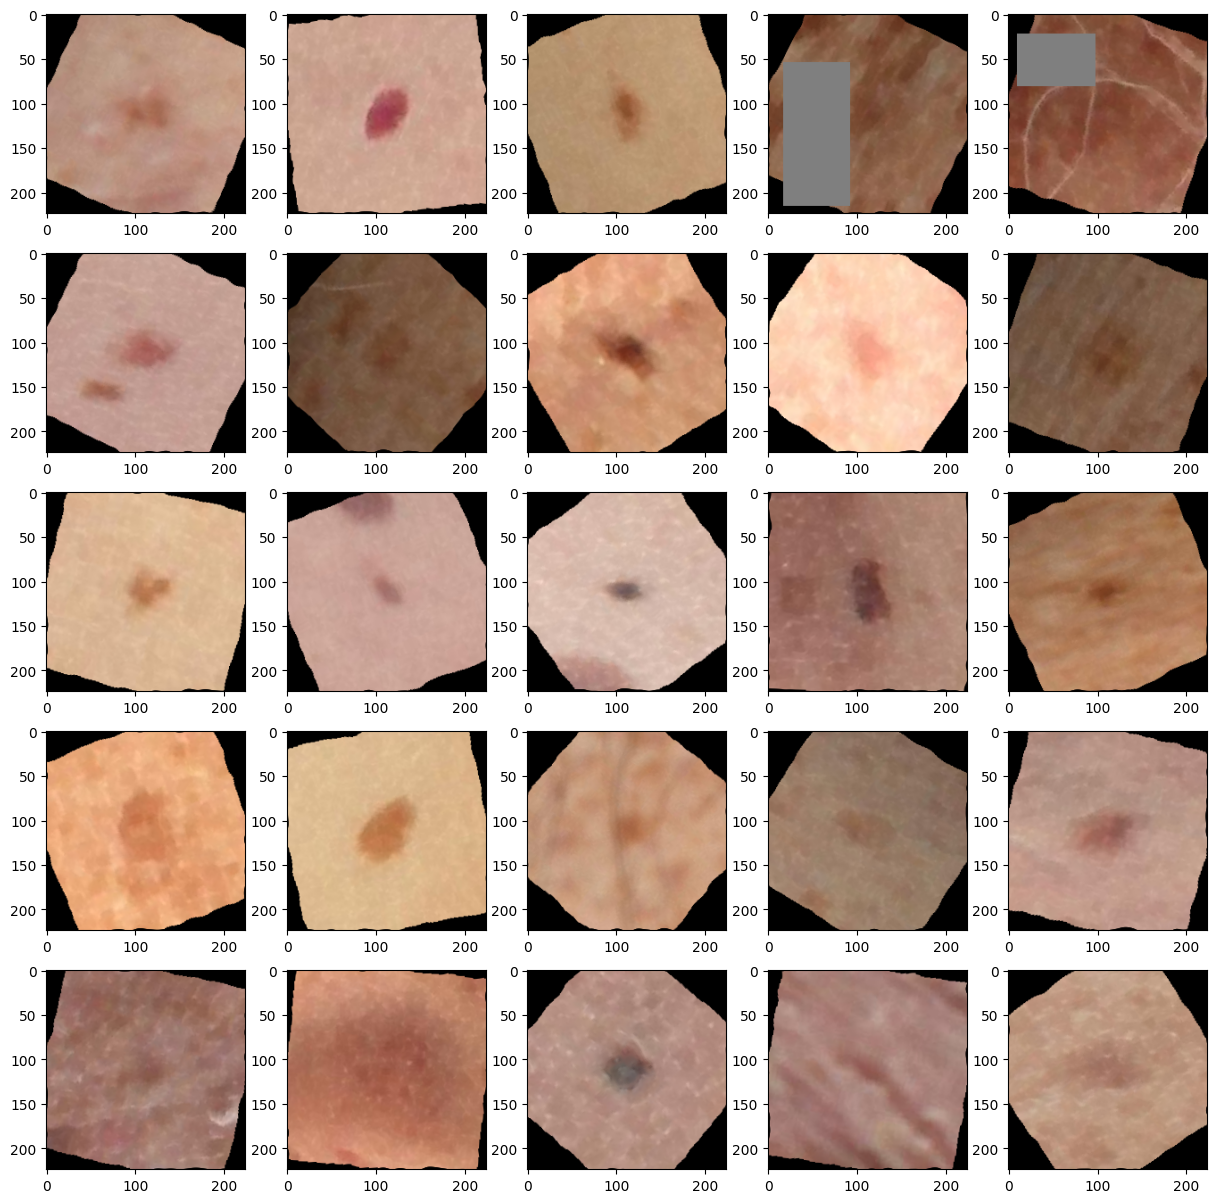

In [221]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for batch, label in data_module.train_dataloader():
  for ax, image in zip(axs.ravel(), batch['image'][:25]):
    ax.imshow(data_module.inverse_transform(image))
  break
plt.show()